CONFIRM CASES


In [ ]:
pip install helper

**Importing the important libraries**

In [3]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import helper
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


**Reading the dataset**

In [6]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv', parse_dates=['Date'])
dataframe['Province/State']=dataframe['Province/State'].fillna('')
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)
dataframe

State                Country        Lat  ...  Confirmed Deaths  Recovered
0                      Afghanistan  33.000000  ...          0      0          0
1                          Albania  41.153300  ...          0      0          0
2                          Algeria  28.033900  ...          0      0          0
3                          Andorra  42.506300  ...          0      0          0
4                           Angola -11.202700  ...          0      0          0
...     ...                    ...        ...  ...        ...    ...        ...
32060        Sao Tome and Principe   0.186360  ...        251      8          4
32061                        Yemen  15.552727  ...        197     33          0
32062                      Comoros -11.645500  ...         34      1          8
32063                   Tajikistan  38.861034  ...       2350     44          0
32064                      Lesotho -29.609988  ...          1      0          0

[32065 rows x 8 columns]

In [7]:
q=dataframe.query('Country=="Germany"')
df=q.fillna('').groupby(['Date'])['Confirmed'].max()
df=pd.DataFrame(df)
df

Confirmed
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17     176369
2020-05-18     176551
2020-05-19     177778
2020-05-20     178473
2020-05-21     179021

[121 rows x 1 columns]

**Spliting the dataset**

In [9]:
train=df[0:97]
test=df[97:]
test

Confirmed
Date                 
2020-04-28     159912
2020-04-29     161539
2020-04-30     163009
2020-05-01     164077
2020-05-02     164967
2020-05-03     165664
2020-05-04     166152
2020-05-05     167007
2020-05-06     168162
2020-05-07     169430
2020-05-08     170588
2020-05-09     171324
2020-05-10     171879
2020-05-11     172576
2020-05-12     173171
2020-05-13     174098
2020-05-14     174478
2020-05-15     175233
2020-05-16     175752
2020-05-17     176369
2020-05-18     176551
2020-05-19     177778
2020-05-20     178473
2020-05-21     179021

In [11]:
# Series to test
column_name = df.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Confirmed cases will be used for the analysis


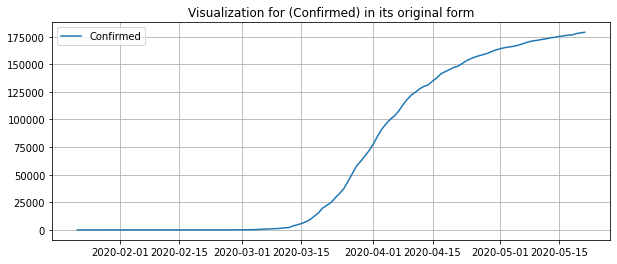

In [12]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [13]:
df.tail()

Confirmed
Date                 
2020-05-17     176369
2020-05-18     176551
2020-05-19     177778
2020-05-20     178473
2020-05-21     179021

In [14]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [15]:
df_to_test.tail()

Confirmed
Date                 
2020-05-17     176369
2020-05-18     176551
2020-05-19     177778
2020-05-20     178473
2020-05-21     179021

In [16]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [17]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [18]:
#Mean absolute percentage error (MAPE) 
def mape(actual, predicted): 
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [19]:
def sarima_configs(seasonal=None):
    """Generate all possible combinations of hyperparameters
    """
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [20]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
     
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [21]:
print(column_name)
results = grid_search(df_to_test)

Confirmed
([(0, 0, 0), (0, 0, 0, 365), 'n'], 98963.02352836657, 67309.36363636363)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 98963.02352836657, 67309.36363636363)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 72288.9135841778, 67665.14725770098)
([(0, 0, 0), (0, 0, 0, 365), 't'], 35875.36911585229, 31394.73718729925)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 25673.49595124428, 21546.672857597063)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 49542.50156962414, 33800.72039190751)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 38476.24100156243, 34972.45530204024)
([(0, 0, 1), (0, 0, 0, 365), 't'], 18085.18141710074, 15428.905348214432)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 15365.880353104605, 11633.41144524437)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 25663.312907208867, 17486.96929180646)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 76454.78701595285, 39660.67402923365)
([(0, 0, 2), (0, 0, 0, 365), 't'], 42831.89967539794, 38389.89372707421)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 32669.337565156435, 15212.528337233625)
([(0, 1, 0), (0, 0, 0, 365), 'n']

In [ ]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]
r2 = results[0][3]
print(column_name)
print(best_combination, best_error, mae, r2)

Confirmed
[(2, 0, 2), (0, 0, 0, 365), 'ct'] 611.9460833333595 420.14156527897245 0.9999288487957007


In [ ]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

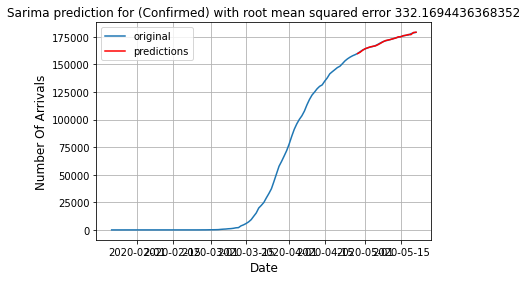

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(test, predictions)
#errors=mape(df_to_test,predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,error))
#plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,errors))
plt.show()

In [ ]:
errors = mape(test, predictions)
errors

3.7520993645932745

In [ ]:
Recovered Cases in Germany'''

' Recovered Cases in Germany'

RECOVERED CASES

In [ ]:
q=dataframe.query('Country=="Germany"')
dfr=q.fillna('').groupby(['Date'])['Recovered'].max()
dfr=pd.DataFrame(dfr)
dfr

Recovered
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17     154011
2020-05-18     155041
2020-05-19     155681
2020-05-20     156966
2020-05-21     158087

[121 rows x 1 columns]

**spliting the dataset**

In [ ]:
trainr=dfr[0:97]
testr=dfr[97:]
testr

Recovered
Date                 
2020-04-28     117400
2020-04-29     120400
2020-04-30     123500
2020-05-01     126900
2020-05-02     129000
2020-05-03     130600
2020-05-04     132700
2020-05-05     135100
2020-05-06     139900
2020-05-07     141700
2020-05-08     141700
2020-05-09     143300
2020-05-10     144400
2020-05-11     145617
2020-05-12     147200
2020-05-13     148700
2020-05-14     150300
2020-05-15     151597
2020-05-16     152600
2020-05-17     154011
2020-05-18     155041
2020-05-19     155681
2020-05-20     156966
2020-05-21     158087

In [ ]:
# Series to test
column_name = dfr.columns[0]
print(" %s cases will be used for the analysis" % column_name)

Region Recovered will be used for the analysis


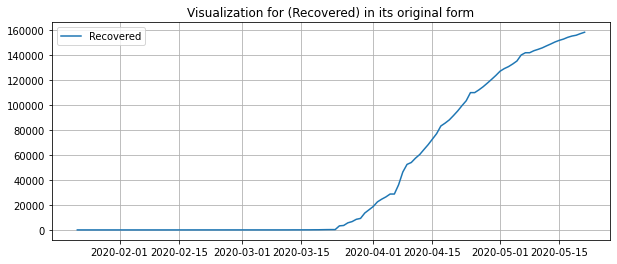

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(dfr, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfr.columns[0])
plt.grid()
plt.show()

In [ ]:
dfr.tail()

Recovered
Date                 
2020-05-17     154011
2020-05-18     155041
2020-05-19     155681
2020-05-20     156966
2020-05-21     158087

In [ ]:
df_to_test = copy.deepcopy(dfr)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [ ]:
df_to_test.tail()

Recovered
Date                 
2020-05-17     154011
2020-05-18     155041
2020-05-19     155681
2020-05-20     156966
2020-05-21     158087

In [ ]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [ ]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [ ]:
def sarima_configs(seasonal=None):
    """Generate all possible combinations of hyperparameters
    """
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [ ]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [ ]:
print(column_name)
results = grid_search(df_to_test)

Recovered
([(0, 0, 0), (0, 0, 0, 365), 'n'], 72498.95344157712, 43807.198347107435, -0.575083830213964)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 72498.95344157712, 43807.198347107435, -0.575083830213964)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 57629.5717082343, 51196.920224028414, 0.004752758927388023)
([(0, 0, 0), (0, 0, 0, 365), 't'], 34869.123419331576, 30858.961315315377, 0.6356470771726297)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 26651.90843327078, 23464.805215653152, 0.7871386445176219)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 36797.04491696089, 22206.79521111782, 0.5942429408592902)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 30588.05872315136, 25441.220725296942, 0.7196219384059337)
([(0, 0, 1), (0, 0, 0, 365), 't'], 17868.38841569383, 15852.78049436184, 0.9043222470309101)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 36527.90446233015, 32863.52100437283, 0.6001567996703774)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 19626.768686089647, 12087.880705922938, 0.8845649204727628)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 34722.2605961

In [ ]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]
r2 = results[0][3]
print(column_name)
print(best_combination, best_error, mae, r2)

Recovered
[(2, 0, 1), (0, 0, 0, 365), 't'] 1211.18041929416 666.8933518682358 0.999560399800731


In [ ]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

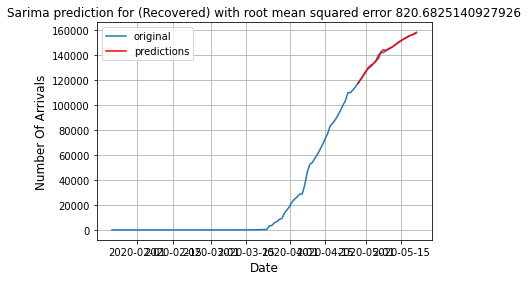

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testr, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [ ]:
mape(testr, predictions)

9.769424091660914

In [ ]:
# Deaths cases

DEATH CASES

In [24]:
q=dataframe.query('Country=="Germany"')
dfd=q.fillna('').groupby(['Date'])['Deaths'].max()
dfd=pd.DataFrame(dfd)
dfd

Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-05-17    7962
2020-05-18    8003
2020-05-19    8081
2020-05-20    8144
2020-05-21    8203

[121 rows x 1 columns]

In [25]:
# Seriies to test
column_name = dfd.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Deaths cases will be used for the analysis


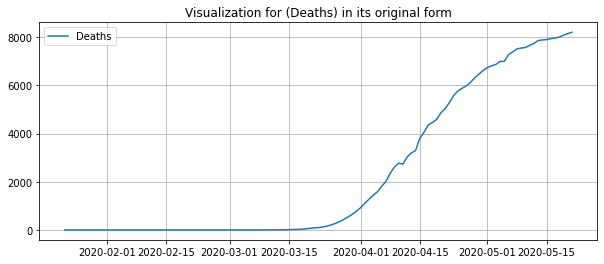

In [26]:
plt.figure(figsize=(10,4))
plt.plot(dfd, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfd.columns[0])
plt.grid()
plt.show()

In [27]:
dfd.tail()

Deaths
Date              
2020-05-17    7962
2020-05-18    8003
2020-05-19    8081
2020-05-20    8144
2020-05-21    8203

In [28]:
traind=dfd[0:97]
testd=dfd[97:]
testd

Deaths
Date              
2020-04-28    6314
2020-04-29    6467
2020-04-30    6623
2020-05-01    6736
2020-05-02    6812
2020-05-03    6866
2020-05-04    6993
2020-05-05    6993
2020-05-06    7275
2020-05-07    7392
2020-05-08    7510
2020-05-09    7549
2020-05-10    7569
2020-05-11    7661
2020-05-12    7738
2020-05-13    7861
2020-05-14    7884
2020-05-15    7897
2020-05-16    7938
2020-05-17    7962
2020-05-18    8003
2020-05-19    8081
2020-05-20    8144
2020-05-21    8203

In [29]:
df_to_test = copy.deepcopy(dfd)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [30]:
df_to_test.tail()

Deaths
Date              
2020-05-17    7962
2020-05-18    8003
2020-05-19    8081
2020-05-20    8144
2020-05-21    8203

In [31]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [32]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [33]:
def sarima_configs(seasonal=None):
    """Generate all possible combinations of hyperparameters
    """
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [34]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [35]:
print(column_name)
results = grid_search(df_to_test)

Deaths
([(0, 0, 0), (0, 0, 0, 365), 'n'], 3802.400117411707, 2299.280991735537)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 3802.400117411707, 2299.280991735537)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 3021.235160592059, 2675.42141930196)
([(0, 0, 0), (0, 0, 0, 365), 't'], 1827.6649879515342, 1627.2757211423423)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 1398.3103017596006, 1239.3954145393732)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 1928.967192311079, 1171.7639570778633)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 3051.2787096411907, 2717.0445161936836)
([(0, 0, 1), (0, 0, 0, 365), 't'], 927.6840584353031, 827.2149781579036)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 1435.6218437781351, 1272.1915048518745)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 1028.0082034814764, 613.8857546904693)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 1681.6053783344962, 1306.0089546304253)
([(0, 0, 2), (0, 0, 0, 365), 't'], 1033.337460166257, 922.189952330587)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 793.6757171796195, 681.1568099478176)
([(0, 1, 0), (0, 0, 0, 365), 'n

In [37]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Deaths
[(2, 0, 1), (0, 0, 0, 365), 't'] 57.991837287632194 33.75321648957875


In [38]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

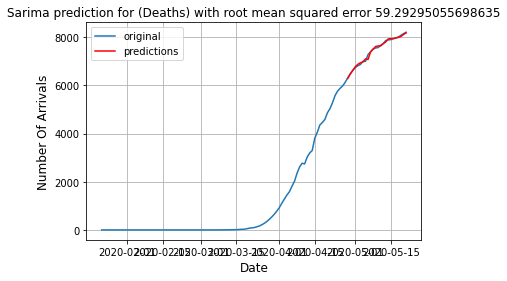

In [39]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testd, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [40]:
mape(testd,predictions)

8.68088231267347